In [2]:
import tensorflow
tensorflow.__version__


'2.17.0'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
!kaggle datasets download 'puneet6060/intel-image-classification'

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 93% 321M/346M [00:01<00:00, 259MB/s]
100% 346M/346M [00:01<00:00, 249MB/s]


In [6]:
!unzip -qq  intel-image-classification.zip


In [7]:
import os, shutil, pathlib

new_base_dir = pathlib.Path("intel_image_classification")

def make_subset(subset_name, count):
    for category in ("buildings", "forest", "glacier", "mountain", "sea", "street"):
      src_folder = pathlib.Path("seg_train/seg_train/"+category)
      file_list = os.listdir(src_folder)[:count]
      dst_folder = new_base_dir / subset_name / category
      os.makedirs(dst_folder)

      for file_name in file_list:
        src_file = os.path.join(src_folder, file_name)
        dst_file = os.path.join(dst_folder, file_name)
        shutil.move(src_file, dst_file)


make_subset("train", count=1000)
make_subset("validation", count=500)
make_subset("test", count=500)

In [8]:
# count the number of images in the train folder
train_dir = new_base_dir / "train"
for category in ("buildings", "forest", "glacier", "mountain", "sea", "street"):
  print(category, len(os.listdir(train_dir / category)))

# Load datasets using image_dataset_from_directory
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

# Display information about the datasets
print(f"Train dataset: {train_dataset.cardinality()} batches")
print(f"Validation dataset: {validation_dataset.cardinality()} batches")
print(f"Test dataset: {test_dataset.cardinality()} batches")

buildings 1000
forest 1000
glacier 1000
mountain 1000
sea 1000
street 1000
Found 6000 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Train dataset: 188 batches
Validation dataset: 94 batches
Test dataset: 94 batches


In [9]:
# Displaying the shapes of the data and labels yielded by the `Dataset`
for data_batch, labels_batch in train_dataset:
    print("Data batch shape:", data_batch.shape)  # Shape of the image data
    print("Labels batch shape:", labels_batch.shape)  # Shape of the corresponding labels
    break  # Exit after the first batch

Data batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
# Define the simple benchmark CNN model
def CNN_benchmark():
    inputs = keras.Input(shape=(180, 180, 3), name='Input')
    x = layers.Rescaling(1./255)(inputs)

    # Basic convolutional layers with no regularization
    x = layers.Conv2D(16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(6, activation="softmax")(x)  # Assuming 6 classes

    model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_benchmark')

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [13]:
model = CNN_benchmark()
model.summary()

Model: "CNN_benchmark"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │         153,606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 177,190 (692.15 KB)

 Trainable params: 177,190 (692.15 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="CNN_benchmark.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

In [15]:
history = model.fit(
    train_dataset,  # Replace with your training dataset
    validation_data=validation_dataset,  # Replace with your validation dataset
    epochs=16,  # Adjust based on your requirements
    callbacks=[checkpoint_callback]
)

Epoch 1/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4811 - loss: 1.2992
Epoch 1: val_accuracy improved from -inf to 0.59333, saving model to CNN_benchmark.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.4816 - loss: 1.2982 - val_accuracy: 0.5933 - val_loss: 0.9620
Epoch 2/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6774 - loss: 0.8352
Epoch 2: val_accuracy improved from 0.59333 to 0.72233, saving model to CNN_benchmark.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6774 - loss: 0.8351 - val_accuracy: 0.7223 - val_loss: 0.7829
Epoch 3/16
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7507 - loss: 0.6786
Epoch 3: val_accuracy improved from 0.72233 to 0.72333, saving model to CNN_benchmark.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7508 - loss: 0.6782 - val_accuracy: 0.7233 - val_loss: 0.7738
Epoch 4/16
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8183 - loss: 0.5119
Epoch 4: val_accuracy 

In [16]:
best_model = keras.models.load_model("CNN_benchmark.keras")

In [17]:
test_model = keras.models.load_model("CNN_benchmark.keras")
test_model.evaluate(test_dataset)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7768 - loss: 0.9150


[0.9497206211090088, 0.7613333463668823]

In [58]:
test_loss, test_accuracy = best_model.evaluate(test_dataset)  # Replace with your test dataset
print(f"Test accuracy of the best performing model: {test_accuracy:.2f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7719 - loss: 0.9229
Test accuracy of the best performing model: 0.76


Question 3: Transfer learning - Feature extraction (45 points)
Alright, now let's see if you can beat your benchmark accuracy by leveraging transfer learning!!

We will applying two types of transfer learning:

feature extraction

fine tuning

Let's start by the feature extraction approach. Feature extraction consists of using the representations learned by a previously trained model to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Feel free to use either VGG16 or Xception or any other architecture available on Keras api: https://keras.io/api/applications/Links to an external site.
Follow the steps we covered in the python lecture (module 5- Python3) and answer the following questions:
1. generate features and labels for the train, validation and test datasets. (10 points)

2. create your own neural network! (the input of this dense network is the feature map created by your VGG16, Xception or any other network you picked to work with for transfer learning) (10 points)

3.train your model using model.fit(). Make sure you save the best one by adding the modelcheckpoint to your callback list. (5 points)

4.plot the loss vs epoch graph! as well as accuracy vs epoch graph. (10 points)


5.report the test set accuracy of your best performing model (the one that you saved by using the modelcheckpoint in the previous step. You might have named it as CNN_transfere_learning_feature_extraction.keras). Were you able to beat the benchmark? by how much? (10 points)

In [19]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images) # this scales pixel values to an appropriate range.
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [22]:
test_features.shape
# recall, the last output in vgg16 has shape (None, 5,5,512)

(3000, 5, 5, 512)

In [23]:
test_labels.shape

(3000,)

In [24]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,639,302 (6.25 MB)

 Trainable params: 1,639,302 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint


In [27]:
modelcheckpoint  = ModelCheckpoint(filepath="CNN_feature_extraction_vgg16.keras",save_best_only=True, monitor="val_loss")
callback_list    = [modelcheckpoint]

In [28]:
history = model.fit(train_features,train_labels,
                              epochs=16, validation_data=(val_features, val_labels),
                              callbacks=callback_list)

Epoch 1/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7957 - loss: 10.5060 - val_accuracy: 0.8783 - val_loss: 7.3042
Epoch 2/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9259 - loss: 4.0390 - val_accuracy: 0.9083 - val_loss: 6.5748
Epoch 3/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9545 - loss: 1.5356 - val_accuracy: 0.9040 - val_loss: 6.5015
Epoch 4/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9597 - loss: 1.2328 - val_accuracy: 0.9053 - val_loss: 6.0973
Epoch 5/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9627 - loss: 1.2418 - val_accuracy: 0.9020 - val_loss: 7.1635
Epoch 6/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9753 - loss: 0.7193 - val_accuracy: 0.9083 - val_loss: 6.9352
Epoch 7/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9754 - loss: 0.6837 - val_accuracy: 0.9013 - val_loss: 8.3089
Epoch 8/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9705 - loss: 0.7058 - val_accuracy: 

In [31]:
metrics = pd.DataFrame(history.history)
metrics.head()

,accuracy,loss,val_accuracy,val_loss
0,0.849500,9.802520,0.878333,7.304231
1,0.922000,4.361874,0.908333,6.574751
2,0.949667,1.872352,0.904000,6.501510
3,0.957167,1.445670,0.905333,6.097324
4,0.965500,1.077316,0.902000,7.163532


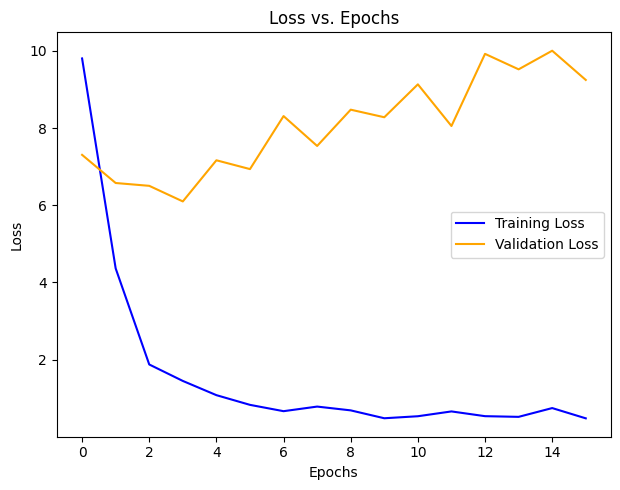

In [32]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss", color='blue')
plt.plot(history.history['val_loss'], label="Validation Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()

plt.tight_layout()
plt.show()


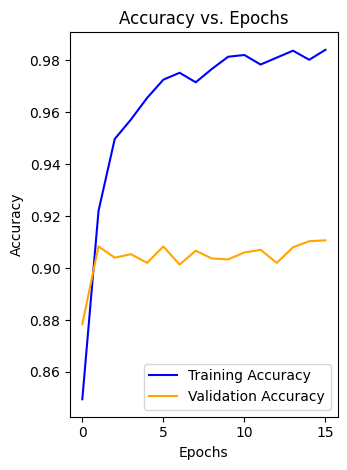

In [33]:
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Training Accuracy", color='blue')
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
test_model = keras.models.load_model("CNN_feature_extraction_vgg16.keras")
test_model.evaluate(test_features, test_labels)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9034 - loss: 6.5593


[7.172515392303467, 0.9020000100135803]

The model accuary is a 90.2% which beats the benchmark of 76%


**Question 4: Transfer learning - Fine tuning (45 points)**

Whatever model architecture you picked from keras.api (vgg16, exception or etc), make sure you unfreeze the last 4 layers (or any other number depending on the model you chose).

In [35]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [36]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [37]:


inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="relu")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), # we pick very low learning rate to limit the magnitude of changes we make to the last 3 conv layers we are fine-tuning.
              metrics=["accuracy"])

In [38]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 12800)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │      1,638,528 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 6)              │            774 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,353,990 (62.39 MB)

 Trainable params: 8,718,726 (33.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [39]:
modelcheckpoint  = ModelCheckpoint(filepath="CNN_fine_tuning_vgg16.keras",save_best_only=True, monitor="val_loss")
callback_list    = [modelcheckpoint]

In [57]:
history = model.fit(train_dataset,
                              epochs=16, validation_data=validation_dataset,
                              callbacks=callback_list)

Epoch 1/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 164ms/step - accuracy: 0.3851 - loss: 2.0504 - val_accuracy: 0.2620 - val_loss: 1.6233
Epoch 2/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.2988 - loss: 1.9593 - val_accuracy: 0.2280 - val_loss: 1.6813
Epoch 3/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 31s 167ms/step - accuracy: 0.2640 - loss: 1.8276 - val_accuracy: 0.1973 - val_loss: 1.7368
Epoch 4/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.2321 - loss: 1.8650 - val_accuracy: 0.1843 - val_loss: 1.7601
Epoch 5/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - accuracy: 0.2185 - loss: 1.8315 - val_accuracy: 0.1747 - val_loss: 1.7774
Epoch 6/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.2197 - loss: 1.7761 - val_accuracy: 0.1743 - val_loss: 1.7780
Epoch 7/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.2052 - loss: 1.8310 - val_accuracy: 0.1767 - val_loss: 1.7738
Epoch 8/16
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.2191 - loss: 1

In [41]:
metrics = pd.DataFrame(history.history)
metrics.head()

,accuracy,loss,val_accuracy,val_loss
0,0.214333,8.402222,0.363000,5.868286
1,0.402667,5.662900,0.606667,3.279195
2,0.550333,4.027799,0.706667,2.052248
3,0.618500,3.191780,0.726333,1.835421
4,0.597500,2.797256,0.550333,1.488606


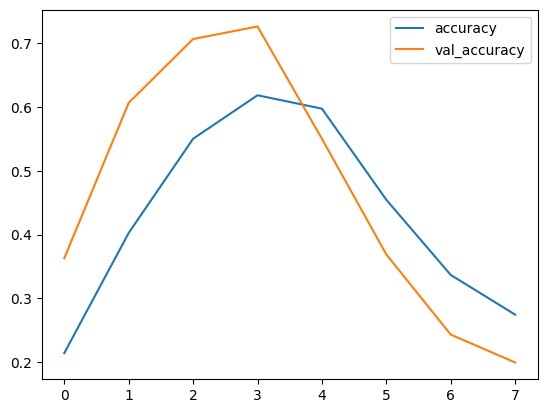

In [42]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

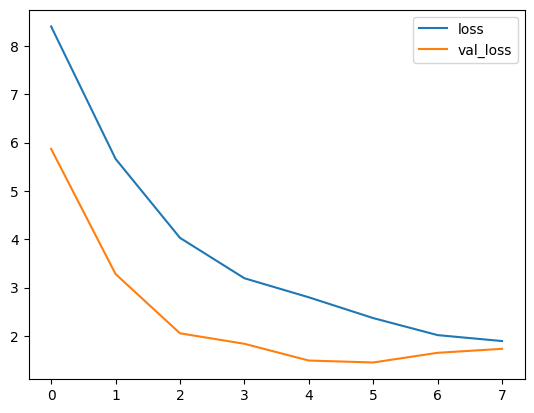

In [43]:
metrics[['loss','val_loss']].plot()
plt.show()

In [60]:
test_model = keras.models.load_model("CNN_fine_tuning_vgg16.keras")
test_model.evaluate(test_dataset)


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.3556 - loss: 1.4479


[1.471677303314209, 0.3583333194255829]

Ac

In [45]:
model = keras.models.load_model("CNN_fine_tuning_vgg16.keras")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_2 (Stack)           │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 12800)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │      1,638,528 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 6)              │            774 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,072,718 (95.64 MB)

 Trainable params: 8,718,726 (33.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 8,718,728 (33.26 MB)

In [46]:
test_dataset.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

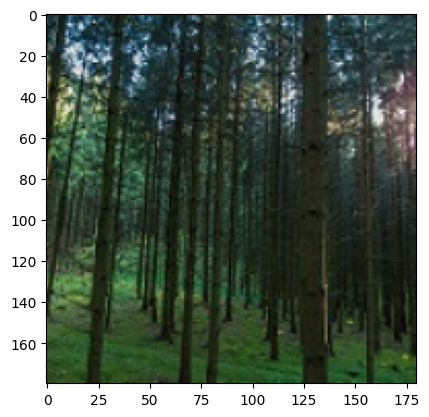

In [47]:
# every single time that you run tf.data.Data, it will shuffle the data.
for image, _ in test_dataset.take(1): # take(N) allows to sample N batches from the dataset.
  plt.imshow(image[1].numpy().astype("uint8"))

In [48]:
# Very important!!! we need to make lables and predictions and images, all in one cell to avoid shuffling.
y_test     = np.array([])
pred_test  = np.array([])
all_images = [] # we want to see which image was misclassified by this monster model :))

for x , y in test_dataset:
  y_test     = np.concatenate([y_test, y])
  pred_test  = np.concatenate([pred_test, model.predict(x, verbose=0).reshape(-1,)])
  all_images.append(x)

In [49]:
test_images = np.concatenate(all_images)
test_images.shape

(3000, 180, 180, 3)

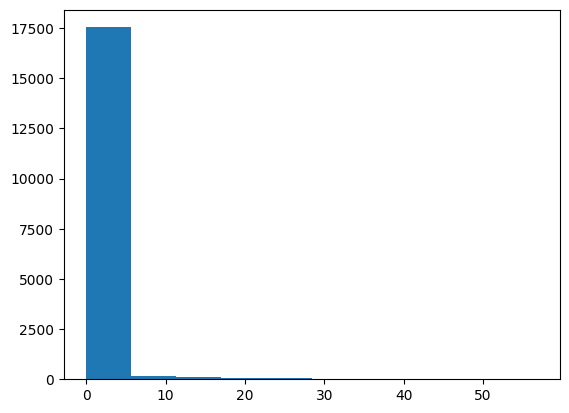

In [50]:
plt.hist(pred_test)
plt.show()

In [51]:
# Assuming `model` is your trained model and `test_dataset` is your test data
predictions = model.predict(test_dataset)  # Shape should be (num_samples, num_classes)

# Get the predicted class labels
predicted_classes = np.argmax(predictions, axis=1)

# If you want to print or evaluate the predicted classes
print(predicted_classes)


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step
[0 0 0 ... 0 0 0]


In [52]:
from sklearn.metrics import classification_report,confusion_matrix

In [53]:

# Now use the classification_report function
print(classification_report(y_test, predicted_classes))


              precision    recall  f1-score   support

         0.0       0.17      0.80      0.27       500
         1.0       0.17      0.10      0.13       500
         2.0       0.18      0.02      0.03       500
         3.0       0.27      0.02      0.03       500
         4.0       0.16      0.04      0.06       500
         5.0       0.16      0.03      0.05       500

    accuracy                           0.17      3000
   macro avg       0.18      0.17      0.10      3000
weighted avg       0.18      0.17      0.10      3000



In [54]:
cm = confusion_matrix(y_test, predicted_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[399  50   7   7  22  15]
 [398  50   8   5  23  16]
 [399  49   8   4  16  24]
 [402  46   9   9  24  10]
 [402  52   6   6  20  14]
 [409  45   7   2  22  15]]


In [55]:
import numpy as np

# Assuming y_test is your array of true labels and predictions contains the model output probabilities
# Example y_test (true labels) and predictions (model output probabilities)
# y_test = np.array([...])  # Replace with your actual test labels
# predictions = model.predict(test_dataset)  # Obtain the predicted probabilities from your model

# Step 1: Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# Step 2: Identify misclassifications
misclass = y_test != predicted_classes  # Boolean array where True indicates a misclassification

# Step 3: Get indices of misclassified samples
misclassified_indices = np.where(misclass)[0]  # Indices of misclassifications

# Step 4: Extract misclassified true labels and predictions
misclassified_true_labels = y_test[misclassified_indices]
misclassified_predictions = predicted_classes[misclassified_indices]

# Print the results
print("Misclassified Indices:", misclassified_indices)
print("True Labels of Misclassified Samples:", misclassified_true_labels)
print("Predicted Labels of Misclassified Samples:", misclassified_predictions)

# Optional: Print the number of misclassifications
num_misclassifications = np.sum(misclass)
print(f"Number of Misclassifications: {num_misclassifications}")


Misclassified Indices: [   1    2    3 ... 2996 2998 2999]
True Labels of Misclassified Samples: [4. 3. 3. ... 5. 3. 3.]
Predicted Labels of Misclassified Samples: [0 0 0 ... 0 0 0]
Number of Misclassifications: 2499


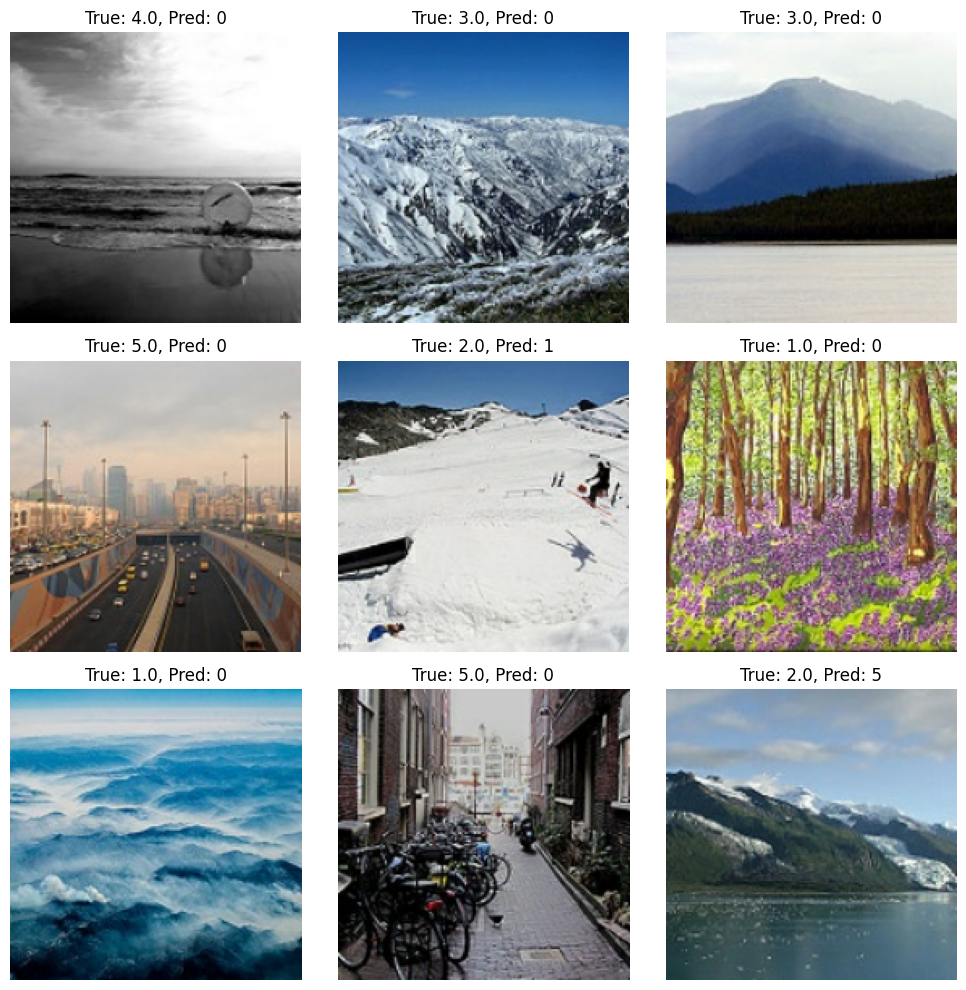

In [56]:
# Step 1: Get indices of misclassified images
misclassified_images = [i for i, x in enumerate(misclass) if x]  # List comprehension to find indices

# Step 2: Plotting the first 9 misclassified images
plt.figure(figsize=(10, 10))
for i, number in enumerate(misclassified_images[:9]):  # Adjust the range to change number of displayed images
    ax = plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns
    plt.imshow(test_images[number].astype("uint8"))  # Display the misclassified image
    plt.title(f'True: {y_test[number]}, Pred: {predicted_classes[number]}')  # Add title with true and predicted labels
    plt.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout
plt.show()